In [1]:
import pandas as pd
import numpy as np
import mat73
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter


/Users/tzp466/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# classification level
LEVEL = "trial" # "sentence" or "trial"

# include stadard deviation features
st_dev_features = True # True or False
max_features = True # True or False

In [3]:
#load all non-dyslexic data
nond_subjects = ["02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "15", "16", "18", "19", "20", "21", "22"] 
#01, 13, 14 and 17 excluded because of POOR calibration or attention disorder

#shuffle subjects so that not always the same data is taken afterwards
print("SHUFFLING SUBJECTS before loading data")
random.shuffle(nond_subjects)

all_nond_data = pd.DataFrame()
for subject in nond_subjects:
    subj_file = pd.read_csv('../ExtractedFeatures/P'+subject+'.csv')
    subj_file = subj_file.fillna(0)
    subj_file.insert(17, 'participantId', subject)
    subj_file.insert(18, 'label', 0) #non-dyslexic

    all_nond_data = pd.concat([all_nond_data, subj_file])

if LEVEL == "sentence":
    all_nond_data["uniqueID"] = all_nond_data["participantId"] + "-" + all_nond_data["speechId"].astype(str) + "-" + all_nond_data["sentenceId"].astype(str)
elif LEVEL == "trial":
    all_nond_data["uniqueID"] = all_nond_data["participantId"] + "-" + all_nond_data["speechId"].astype(str) + "-" + all_nond_data["trialId"].astype(str)

print()
print(len(all_nond_data.uniqueID.unique()), " samples.")
print(len(all_nond_data), " words.")
        

SHUFFLING SUBJECTS before loading data

6155  samples.
446434  words.


In [5]:
#load all dyslexic data
dys_subjects = ["23","24", "25", "26", "27", "28", "29", "30", "31", "33", "34", "35", "36", "37", "38", "39", "40", "41"] 
# excluding P32 because no dyslexia screening result

all_dyslexic_data = pd.DataFrame()
for subject in dys_subjects:
    subj_file = pd.read_csv('../ExtractedFeatures/P'+subject+'.csv')
    subj_file = subj_file.fillna(0)
    subj_file.insert(17, 'participantId', subject)
    subj_file.insert(18, 'label', 1) #dyslexic
        
    all_dyslexic_data = pd.concat([all_dyslexic_data, subj_file])

if LEVEL == "sentence":
    all_dyslexic_data["uniqueID"] = all_dyslexic_data["participantId"] + "-" + all_dyslexic_data["speechId"].astype(str) + "-" + all_dyslexic_data["sentenceId"].astype(str)
elif LEVEL == "trial":
    all_dyslexic_data["uniqueID"] = all_dyslexic_data["participantId"] + "-" + all_dyslexic_data["speechId"].astype(str) + "-" + all_dyslexic_data["trialId"].astype(str)

print()
print(len(all_dyslexic_data.uniqueID.unique()), " samples.")
print(len(all_dyslexic_data), " words.")


5093  samples.
373791  words.


In [6]:
# get an equal number of samples per class and join dataframes
max_no_samples = len(all_dyslexic_data.uniqueID.unique())
print(max_no_samples, " dyslexic samples.")

grouped_all_nond_data = all_nond_data.groupby('uniqueID')
list_ds = [x[1] for x in list(grouped_all_nond_data)[:max_no_samples]]
downsampled_nond = pd.concat(list_ds)

print(len(downsampled_nond), "downsampled non-dyslexic words.")

all_subjects_data = pd.concat([all_dyslexic_data,downsampled_nond])
print(len(all_subjects_data.uniqueID.unique()), " in total.")

5093  dyslexic samples.
369633 downsampled non-dyslexic words.
10186  in total.


In [7]:
# get mean sentence/trial features
aggregated_data = all_subjects_data.groupby('uniqueID').mean()
aggregated_data = aggregated_data.drop(columns=['part', 'wordId', 'sentenceId', 'speechId', 'trialId', 'paragraphId'])
aggregated_data = aggregated_data.add_prefix('mean_')
aggregated_data = aggregated_data.rename(columns={'mean_label': 'label'})

<ipython-input-7-4e0461f71414>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = all_subjects_data.groupby('uniqueID').mean()


In [8]:
# get standard deviation features
std_feats = all_subjects_data.groupby('uniqueID').std()
std_feats = std_feats.drop(columns=['part', 'wordId', 'sentenceId', 'speechId', 'trialId', 'paragraphId', 'label'])
std_feats = std_feats.add_prefix('std_')
aggregated_data = pd.concat([aggregated_data, std_feats], axis=1)

<ipython-input-8-f580535642c4>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_feats = all_subjects_data.groupby('uniqueID').std()


In [9]:
# get max value features
max_feats = all_subjects_data.groupby('uniqueID').max()
max_feats = max_feats.drop(columns=['part', 'wordId', 'sentenceId', 'speechId', 'trialId', 'paragraphId', 'label'])
max_feats = max_feats.add_prefix('max_')
aggregated_data = pd.concat([aggregated_data, max_feats], axis=1)

In [10]:
# remove NaNs
print(len(aggregated_data))
aggregated_data = aggregated_data.dropna()
print(len(aggregated_data))

10186
10186


In [11]:
# shuffle samples in dataset
shuffled_samples = aggregated_data.sample(n=len(aggregated_data))

In [12]:
# define features to be used
feature_names = ['mean_landing_position', 'mean_word_first_fix_dur', 'mean_word_first_pass_dur', 'mean_word_go_past_time', 'mean_word_mean_fix_dur', 'mean_word_total_fix_dur', 'mean_number_of_fixations', 'mean_word_mean_sacc_dur', 'mean_word_peak_sacc_velocity']
if st_dev_features == True:
    feature_names = feature_names + ['std_landing_position', 'std_word_first_fix_dur', 'std_word_first_pass_dur', 'std_word_go_past_time', 'std_word_mean_fix_dur', 'std_word_total_fix_dur', 'std_number_of_fixations', 'std_word_mean_sacc_dur', 'std_word_peak_sacc_velocity']
else:
    feature_names = feature_names
if max_features == True:
    feature_names = feature_names + ['max_landing_position', 'max_word_first_fix_dur', 'max_word_first_pass_dur', 'max_word_go_past_time', 'max_word_mean_fix_dur', 'max_word_total_fix_dur', 'max_number_of_fixations', 'max_word_mean_sacc_dur', 'max_word_peak_sacc_velocity']
else:
    feature_names = feature_names 
print(feature_names)
print(len(feature_names), " features.")

['mean_landing_position', 'mean_word_first_fix_dur', 'mean_word_first_pass_dur', 'mean_word_go_past_time', 'mean_word_mean_fix_dur', 'mean_word_total_fix_dur', 'mean_number_of_fixations', 'mean_word_mean_sacc_dur', 'mean_word_peak_sacc_velocity', 'std_landing_position', 'std_word_first_fix_dur', 'std_word_first_pass_dur', 'std_word_go_past_time', 'std_word_mean_fix_dur', 'std_word_total_fix_dur', 'std_number_of_fixations', 'std_word_mean_sacc_dur', 'std_word_peak_sacc_velocity', 'max_landing_position', 'max_word_first_fix_dur', 'max_word_first_pass_dur', 'max_word_go_past_time', 'max_word_mean_fix_dur', 'max_word_total_fix_dur', 'max_number_of_fixations', 'max_word_mean_sacc_dur', 'max_word_peak_sacc_velocity']
27  features.


In [13]:
# split data
x_value = shuffled_samples[feature_names]
y_value = shuffled_samples['label']
        
X_train, X_test, y_train, y_test = train_test_split(x_value, y_value, test_size=0.1)
print(len(X_train), "train samples.")
print(len(X_test), "test samples.")

9167 train samples.
1019 test samples.


In [14]:
# create df for X_test for misclassification

df_test = X_test

In [15]:
# scale data
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train) 
X_test = scaling.transform(X_test)

## Classification Models

In [16]:
# SVM grid search
def grid_lin(X_train,y_train):

    svc = svm.SVC(kernel='linear') 

    parameters = {'C': [0.1, 1, 10, 100], 'kernel': ['linear']}

    clf_gs = GridSearchCV(svc, parameters)
    clf_gs.fit(X_train, y_train.ravel())

    print(clf_gs.best_estimator_, clf_gs.best_params_) 

    return

In [17]:
# run grid search
#grid_lin(X_train,y_train)

# trial level grid search results: SVC(C=100, kernel='linear') {'C': 100, 'kernel': 'linear'}
# sentence level grid search results: SVC(C=100, kernel='linear') {'C': 100, 'kernel': 'linear'}

In [18]:
# SVM classifier    
clf = svm.SVC(kernel ='linear', C=100, probability=True)  

clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)

In [19]:
# report precision, recall and f1 scores
target_names = ['non-dyslexic', 'dyslexic']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

non-dyslexic       0.79      0.89      0.84       499
    dyslexic       0.88      0.78      0.83       520

    accuracy                           0.83      1019
   macro avg       0.84      0.83      0.83      1019
weighted avg       0.84      0.83      0.83      1019



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


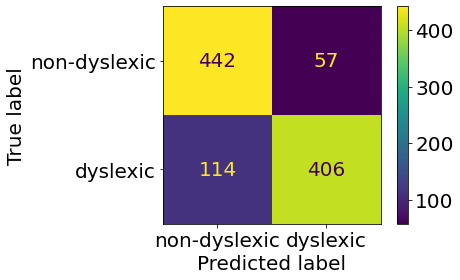

In [20]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)

font = {'family' : 'normal',
    'weight' : 'normal',
    'size'   : 20}
plt.rc('font', **font)

cm_display.plot()


In [21]:
# identify misclassified data
    
incorrect_pred = X_test[y_pred != y_test]
incorrect_pred_index = [i for i in range(len(y_pred)) if y_pred[i] != y_test[i]]

each_mis = []
for index in incorrect_pred_index:
    each_mis.append(df_test.index[index])

each_mis_ids = [x[:2] for x in each_mis]
print("\n Count of each misclassified participant:", Counter(each_mis_ids).most_common())
misclass_file = open("svm_"+LEVEL+"_level_misclassifications_std"+str(st_dev_features)+"_max"+str(max_features)+".txt", "a")
print(Counter(each_mis_ids).most_common(), file=misclass_file)
misclass_file.close()


 Count of each misclassified participant: [('28', 29), ('07', 18), ('37', 18), ('23', 16), ('12', 16), ('24', 14), ('35', 14), ('15', 10), ('41', 9), ('10', 7), ('29', 3), ('34', 2), ('25', 2), ('03', 2), ('40', 2), ('27', 1), ('38', 1), ('30', 1), ('36', 1), ('19', 1), ('08', 1), ('26', 1), ('02', 1), ('11', 1)]


In [22]:
results_svm = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
result_file = open("svm_"+LEVEL+"_level_results_std"+str(st_dev_features)+"_max"+str(max_features)+".txt", "a")
print(results_svm, file=result_file)
result_file.close()

In [23]:
# Random forest grid search
def gridsearch(X_train,y_train):
    """Grid search to tune RF parametres"""     
    rf = RandomForestClassifier()
    rf_params = {'n_estimators': [1, 10, 100, 200], 'max_depth': [1, 3, 5, 7, 9], 'max_features': ['sqrt', 'log2', 'auto']}
    
    clf_gs = GridSearchCV(rf, rf_params)
  
    clf_gs.fit(X_train, y_train.ravel())
    
    # print the grid search results
    print(clf_gs.best_estimator_, clf_gs.best_params_)
    

In [24]:
# run grid search
#gridsearch(X_train,y_train)

# trial level grid search results: RandomForestClassifier(max_depth=9, max_features='log2') {'max_depth': 9, 'max_features': 'log2', 'n_estimators': 100}
# sentence level grid search results: RandomForestClassifier(max_depth=9, max_features='sqrt', n_estimators=200) {'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 200}


In [25]:
# Random forest classifier
clf = RandomForestClassifier(max_depth=9, max_features='sqrt', n_estimators=200)

clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)

In [26]:
target_names = ['non-dyslexic', 'dyslexic']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

non-dyslexic       0.84      0.89      0.86       499
    dyslexic       0.89      0.84      0.86       520

    accuracy                           0.86      1019
   macro avg       0.86      0.86      0.86      1019
weighted avg       0.86      0.86      0.86      1019



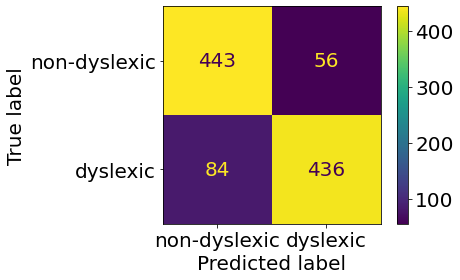

In [27]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels = clf.classes_)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_names)

cm_display.plot()

In [28]:
# identify misclassified data
incorrect_pred = X_test[y_pred != y_test]
incorrect_pred_index = [i for i in range(len(y_pred)) if y_pred[i] != y_test[i]]

each_mis = []
for index in incorrect_pred_index:
    each_mis.append(df_test.index[index])

each_mis_ids = [x[:2] for x in each_mis]
print("\n Count of each misclassified participant:", Counter(each_mis_ids).most_common())
misclass_file = open("rf_"+LEVEL+"_level_misclassifications_std"+str(st_dev_features)+"_max"+str(max_features)+".txt", "a")
print(Counter(each_mis_ids).most_common(), file=misclass_file)
misclass_file.close()


 Count of each misclassified participant: [('10', 20), ('28', 16), ('35', 14), ('24', 12), ('23', 12), ('12', 10), ('07', 9), ('37', 9), ('15', 8), ('41', 8), ('27', 4), ('25', 3), ('03', 3), ('19', 2), ('34', 2), ('29', 1), ('36', 1), ('08', 1), ('16', 1), ('11', 1), ('30', 1), ('09', 1), ('40', 1)]


In [29]:
results_rf = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
result_file = open("rf_"+LEVEL+"_level_results_std"+str(st_dev_features)+"_max"+str(max_features)+".txt", "a")
print(results_rf, file=result_file)
result_file.close()

## Clustering Model

In [30]:
# k-means clustering
from sklearn.cluster import KMeans

# cluster on all data, no need for train/test split
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_value)
clus_data = scaling.transform(x_value) 

kmeans = KMeans(n_clusters=2)
label = kmeans.fit_predict(clus_data)
target_names = ['non-dyslexic', 'dyslexic']
# compare cluster labels to ground truth
print(classification_report(y_value, label, target_names=target_names))

# cannot plot in 2D this because the features have more dimensions

              precision    recall  f1-score   support

non-dyslexic       0.67      0.88      0.76      5093
    dyslexic       0.82      0.57      0.67      5093

    accuracy                           0.72     10186
   macro avg       0.75      0.72      0.72     10186
weighted avg       0.75      0.72      0.72     10186



In [31]:
# save clustering results
results_cluster = classification_report(y_value, label, target_names=target_names, output_dict=True)
result_file_cluster = open("kmeans_"+LEVEL+"_level_results_std"+str(st_dev_features)+"_max"+str(max_features)+".txt", "a")
print(results_cluster, file=result_file_cluster)
result_file_cluster.close()


In [32]:
# tSNE visualization of high dimensional data
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)

In [35]:
# fit TSNE
z = tsne.fit_transform(clus_data) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10186 samples in 0.001s...
[t-SNE] Computed neighbors for 10186 samples in 2.615s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10186
[t-SNE] Computed conditional probabilities for sample 2000 / 10186
[t-SNE] Computed conditional probabilities for sample 3000 / 10186
[t-SNE] Computed conditional probabilities for sample 4000 / 10186
[t-SNE] Computed conditional probabilities for sample 5000 / 10186
[t-SNE] Computed conditional probabilities for sample 6000 / 10186
[t-SNE] Computed conditional probabilities for sample 7000 / 10186
[t-SNE] Computed conditional probabilities for sample 8000 / 10186
[t-SNE] Computed conditional probabilities for sample 9000 / 10186
[t-SNE] Computed conditional probabilities for sample 10000 / 10186
[t-SNE] Computed conditional probabilities for sample 10186 / 10186
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.676971
[t-SNE] KL 

<AxesSubplot:xlabel='comp-1', ylabel='comp-2'>

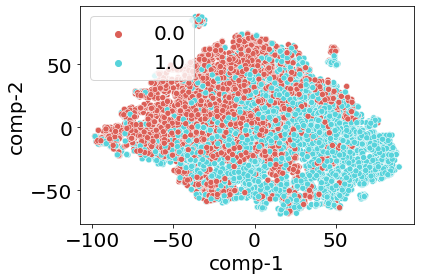

In [36]:
df = pd.DataFrame()
df["y"] = y_value
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=df, legend="full")
